In [1]:
# Code to wrap text in output cells on Colab to see the output clearly
# From https://github.com/jupyter/notebook/issues/6274
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

**Sentiment Analysis of IMDB Movie Reviews**

**Import necessary libraries**

In [2]:
#Load the libraries
!pip install numpy pandas seaborn textblob matplotlib nltk scikit-learn wordcloud bs4 spacy 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score, f1_score




In [3]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [4]:
!pip install "tensorflow<2.11"

In [5]:
!pip install transformers flax

In [6]:
#importing the training data
!wget https://raw.githubusercontent.com/udbhav-44/BCS-Lluminating-Language/master/Week%201/movie.csv

--2024-06-05 11:34:30--  https://raw.githubusercontent.com/udbhav-44/BCS-Lluminating-Language/master/Week%201/movie.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52724248 (50M) [text/plain]
Saving to: 'movie.csv.10'

movie.csv.10        100%[===================>]  50.28M  --.-KB/s    in 0.1s    

2024-06-05 11:34:30 (338 MB/s) - 'movie.csv.10' saved [52724248/52724248]



**Import the training dataset**

In [7]:
import os
# Check current working directory
current_directory = os.getcwd()
print(f"Current Directory: {current_directory}")

# List files in the current directory
files_in_directory = os.listdir(current_directory)
print(f"Files in Directory: {files_in_directory}")

Current Directory: /home/studio-lab-user/sagemaker-studiolab-notebooks
Files in Directory: ['Getting Started.ipynb', 'images', '.ipynb_checkpoints', 'movie.csv', 'movie.csv.1', 'movie.csv.2', 'FinalWeek2Task_by_Aritra(230191)_Using_Transformers_DirectPipeline_StudioLab.ipynb', 'movie.csv.3', 'movie.csv.4', 'my_awesome_model', 'movie.csv.5', 'movie.csv.6', 'Final_Week2Task_by_Aritra(230191)_Using_Transformers_CustomPipeline_Bertweet.ipynb', 'movie.csv.7', 'movie.csv.8', 'movie.csv.9', 'FinalWeek2Task_by_Aritra(230191)_Using_Transformers_Roberta-Base-Finetuned_DirectPipeline_StudioLab.ipynb', 'movie.csv.10']


In [8]:
imdb_data=pd.read_csv("/home/studio-lab-user/sagemaker-studiolab-notebooks/movie.csv")
print(imdb_data.shape)
imdb_data.head(10)

(40000, 2)


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
5,A terrible movie as everyone has said. What ma...,0
6,Finally watched this shocking movie last night...,1
7,I caught this film on AZN on cable. It sounded...,0
8,It may be the remake of 1987 Autumn's Tale aft...,1
9,My Super Ex Girlfriend turned out to be a plea...,1


**Exploratery data analysis**

In [9]:
#Summary of the dataset
imdb_data.describe()

,label
count,40000.000000
mean,0.499525
std,0.500006
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


**Sentiment count**

In [10]:
#sentiment count
imdb_data['label'].value_counts()

label
0    20019
1    19981
Name: count, dtype: int64

Data is balanced. There is NO Value other than 0 or 1 in the sentiment column. Clearly NO missing entries as all 40000 entries we can see filled with 0 or 1.

In [11]:
#Checking for Duplicates
duplicate = imdb_data[imdb_data.duplicated()]

print("Duplicate Rows :")

# Print the resultant Dataframe
duplicate

Duplicate Rows :


,text,label
2164,"I find it rather useless to comment on this ""m...",0
3236,An absolutely atrocious adaptation of the wond...,0
3428,When I first saw this film it was not an impre...,0
3652,Before I watched this tv movie I did not know ...,1
3787,What a clunker!<br /><br />It MUST have been m...,0
...,...,...
39229,I Enjoyed Watching This Well Acted Movie Very ...,1
39246,You do realize that you've been watching the E...,0
39508,(Spoilers)<br /><br />Oh sure it's based on Mo...,0
39681,It's been a long time since I last saw a movie...,0


In [12]:
#Seems Like we have duplicate rows. Now time to delete them
imdb_data.drop_duplicates(inplace=True)
print(imdb_data)


                                                    text  label
0      I grew up (b. 1965) watching and loving the Th...      0
1      When I put this movie in my DVD player, and sa...      0
2      Why do people who do not know what a particula...      0
3      Even though I have great interest in Biblical ...      0
4      Im a die hard Dads Army fan and nothing will e...      1
...                                                  ...    ...
39995  "Western Union" is something of a forgotten cl...      1
39996  This movie is an incredible piece of work. It ...      1
39997  My wife and I watched this movie because we pl...      0
39998  When I first watched Flatliners, I was amazed....      1
39999  Why would this film be so good, but only gross...      1

[39723 rows x 2 columns]


In [13]:
#Checking for Duplicates again for assurance
duplicate = imdb_data[imdb_data.duplicated()]

print("Duplicate Rows :")

# Print the resultant Dataframe
duplicate

Duplicate Rows :


,text,label


No duplicate entries now!!!!

In [14]:
#separating the positive and negative reviews, to analyse and furhter for train-test split
pos_rev = imdb_data[imdb_data['label']==1]
neg_rev = imdb_data[imdb_data['label']==0]

#The data is clearly not imbalanced
print("No. of Positive Reviews:", len(pos_rev))
print("No of Negative Reviews:", len(neg_rev))

No. of Positive Reviews: 19908
No of Negative Reviews: 19815


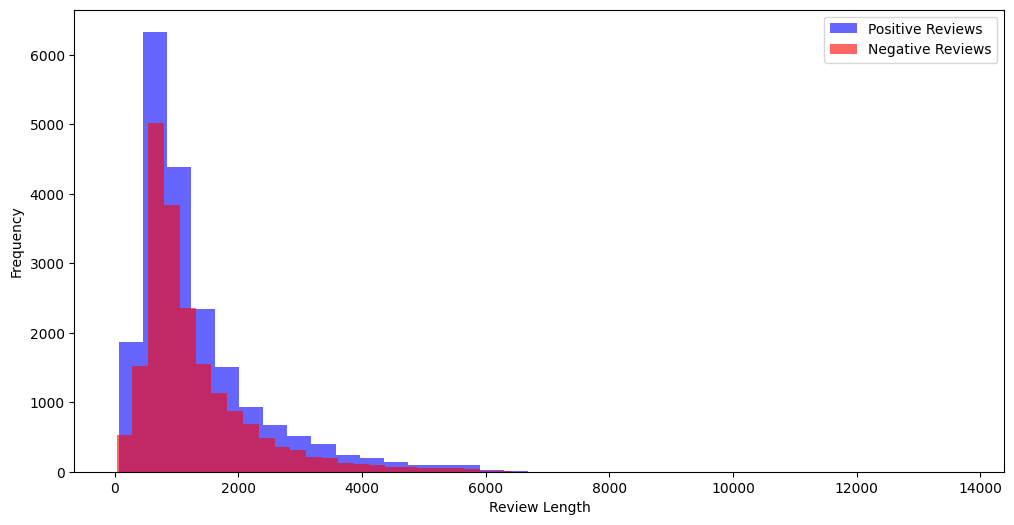

<Axes: xlabel='label', ylabel='count'>

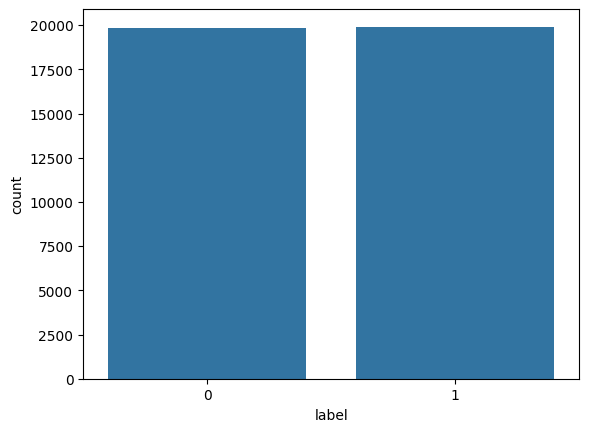

In [15]:
# Data Visualization
# How does the length of the reviews vs the sentiment look like
imdb_data['length'] = imdb_data['text'].apply(len)
imdb_data.head()

# Sentiment vs Length
plt.figure(figsize=(12,6))
imdb_data[imdb_data['label']==1]['length'].plot(bins=35, kind='hist', color='blue', label='Positive Reviews', alpha=0.6)
imdb_data[imdb_data['label']==0]['length'].plot(bins=35, kind='hist', color='red', label='Negative Reviews', alpha=0.6)
plt.legend()
plt.xlabel("Review Length")
plt.show()

sns.countplot(x='label', data=imdb_data)

# You can also plot the wordclouds (would make more sense after processing the data)

In [16]:
#Removing the html strips from the text as it may cause unnessarily increase in the no. of tokens with no added meaning. this is the only part of the data pre-processing which according to me is relevent.
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the noisy text by joining the two functions
def denoise_text(text):
    text = strip_html(text)
    return text
#Apply function on text column in the dataframe
imdb_data['text']=imdb_data['text'].apply(denoise_text)

/tmp/ipykernel_173/4238394898.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


**The Dataset of reviews**

In [17]:
num_rows = 5000 #Definign the no. of rows which you wanna take to train the model faster
reviews=imdb_data.text
reviews_list = reviews[:num_rows].tolist() #Converted the column to a list
print(reviews_list[:5])# Print the first 5 elements to verify
print(len(reviews_list))
review_data=np.array(reviews_list) #Converted into a NumPy array if needed
print(review_data)

['I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.', "When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping t

# Truncating to Fit into the model with at max 512 tokens on board for each text


## Truncation By Method 1

In [18]:

# Directly truncate to a max length of characters


char_limit = 1000

truncated_reviews_list_1=[]

for review in reviews_list:
    words = review.split()
    output = []
    for word in words:
        if len(' '.join(output + [word])) > char_limit:
            break
        output.append(word)

    truncated_reviews_list_1.append(' '.join(output))


In [19]:
# Print the first 5 truncated reviews to verify
print(truncated_reviews_list_1[:5])

['I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.', "When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping t

## Truncation By Method 2

In [20]:
# Trunctaion By Method 2
# Directly truncate to a max no of words

word_limit = 270

truncated_reviews_list_2=[]

for review in reviews_list:
    words = review.split()
    output = []
    i=0
    for word in words:
        if i==word_limit:
            break
        output.append(word)
        i+=1

    truncated_reviews_list_2.append(' '.join(output))
# Notice when after breaking a string into a bunch of words and then joining them by join command ensures that there is a space after each word

In [21]:
# Print the first 5 truncated reviews to verify
print(truncated_reviews_list_2[:5])

['I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.', "When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping t

## Truncation by Method 3

In [22]:
from transformers import AutoTokenizer

In [23]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Function to truncate reviews to a maximum of 512 tokens But I shall take the mergin to be little lesser to aviod any circumstances
def truncate_reviews_by_tokens(reviews, max_token_length):
    truncated_reviews = []
    for review in reviews:
        # Tokenize and truncate the review
        tokens = tokenizer(review, truncation=True, max_length=max_token_length, return_tensors="pt")
        # Convert tokens back to string
        truncated_review = tokenizer.decode(tokens['input_ids'][0], skip_special_tokens=True)
        truncated_reviews.append(truncated_review)
    return truncated_reviews

In [40]:
# Truncate the reviews
truncated_reviews_list_3 = truncate_reviews_by_tokens(reviews_list,460)
print(truncated_reviews_list_3[:5])# Print the first 5 elements to verify

['I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.', "When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping t

In [25]:
imdb_data.head(20)
#To check the row which is the most lemgthy and hence can be used to check if it's actually truncated or not

,text,label,length
0,I grew up (b. 1965) watching and loving the Th...,0,874
1,"When I put this movie in my DVD player, and sa...",0,1811
2,Why do people who do not know what a particula...,0,983
3,Even though I have great interest in Biblical ...,0,351
4,Im a die hard Dads Army fan and nothing will e...,1,983
5,A terrible movie as everyone has said. What ma...,0,596
6,Finally watched this shocking movie last night...,1,1377
7,I caught this film on AZN on cable. It sounded...,0,1489
8,It may be the remake of 1987 Autumn's Tale aft...,1,1137
9,My Super Ex Girlfriend turned out to be a plea...,1,1468


In [26]:
print(truncated_reviews_list_3[16]) # As it has origignally very long

i really wanted to be able to give this film a 10. i've long thought it was my favorite of the four modern live - action batman films to date ( and maybe it still will be - - i have yet to watch the schumacher films again ). i'm also starting to become concerned about whether i'm somehow subconsciously being contrarian. you see, i always liked the schumacher films. as far as i can remember, they were either 9s or 10s to me. but the conventional wisdom is that the two tim burton directed films are far superior. i had serious problems with the first burton batman this time around - - i ended up giving it a 7 - - and apologize as i might, i just couldn't help feel that batman returns just has too many small direction, plot and script problems scattered throughout to justify a 10. but burton _ almost _ trumps the problems with sheer force of style, and even though there are a lot of small flaws, batman returns is still a great film, especially if you're a burton fan, as batman returns has 

It works!! As 5800 characters has been reduced to 2055 characters.

In [27]:
#transformed sentiment data
sentiment_data=np.array(imdb_data['label'][:num_rows].tolist())
print(sentiment_data)
print(sentiment_data.shape)

[0 0 0 ... 1 0 0]
(5000,)


# Using Transformers by Direct Pipeline

In [28]:
from transformers import pipeline, AutoModelForSequenceClassification
model_name = "textattack/roberta-base-SST-2"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer=AutoTokenizer.from_pretrained(model_name)
sentiment_classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)



2024-06-05 11:34:47.747562: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-05 11:34:49.628225: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-05 11:34:49.628385: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-05 11:34:49.628394: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make su

config.json:   0%|          | 0.00/525 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at textattack/roberta-base-SST-2 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

# Predicting the output for Truncation by Max Character Length

In [29]:
predictions_1 = sentiment_classifier(truncated_reviews_list_1)

In [30]:
# Function to convert predictions to binary values
def convert_predictions_to_binary(predictions, threshold=0.5):
    binary_predictions = []
    for prediction in predictions:
        label = prediction['label']
        score = prediction['score']
        
        if label == 'POSITIVE' and score >= threshold:
            binary_predictions.append(1)
        elif label == 'NEGATIVE' and score >= threshold:
            binary_predictions.append(0)
        else:
            binary_predictions.append(0)  # Default to 0 if score is below the threshold

    return np.array(binary_predictions)

# Convert the list of predictions to binary values
prediction_sentiments_array_1 = convert_predictions_to_binary(predictions_1)

print(prediction_sentiments_array_1)
print(sentiment_data)

[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


**Accuracy of the transformer model by Accuracy Score, F1 Score, ROC-AUC Score**

In [31]:
# Calculate accuracy score
accuracy_1 = accuracy_score(sentiment_data, prediction_sentiments_array_1)
print("accuracy_score:", accuracy_1)

# Calculate ROC AUC score
roc_auc_1 = roc_auc_score(sentiment_data, prediction_sentiments_array_1)
print("roc_auc_score:", roc_auc_1)

# Calculate F1 score
f1_1 = f1_score(sentiment_data, prediction_sentiments_array_1)
print("f1_score:", f1_1)

accuracy_score: 0.516
roc_auc_score: 0.5
f1_score: 0.0


**Print the classification report**

In [32]:
#Classification report for bag of words
report_1=classification_report(sentiment_data,prediction_sentiments_array_1,target_names=['Positive','Negative'])
print(report_1)

#Positive means 1 label and negative means 0 label

              precision    recall  f1-score   support

    Positive       0.52      1.00      0.68      2580
    Negative       0.00      0.00      0.00      2420

    accuracy                           0.52      5000
   macro avg       0.26      0.50      0.34      5000
weighted avg       0.27      0.52      0.35      5000



/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

**Confusion matrix**

[[   0 2420]
 [   0 2580]]


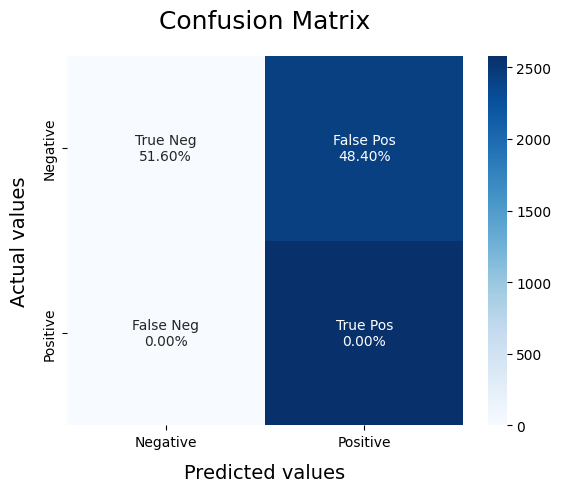

In [33]:
#confusion matrix_1
cm_1=confusion_matrix(sentiment_data,prediction_sentiments_array_1,labels=[1,0])
print(cm_1)


categories = ['Negative', 'Positive']
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_percentages = ['{0:.2%}'.format(value) for value in cm_1.flatten() / np.sum(cm_1)]

# Arrange labels in the correct order
labels = [
    f'{group_names[3]}\n{group_percentages[3]}',  # True Neg
    f'{group_names[1]}\n{group_percentages[1]}',  # False Pos
    f'{group_names[2]}\n{group_percentages[2]}',  # False Neg
    f'{group_names[0]}\n{group_percentages[0]}',  # True Pos
]

# Reshape the labels to match the confusion matrix shape
labels = np.asarray(labels).reshape(2, 2)

sns.heatmap(cm_1, annot=labels, cmap='Blues', fmt='',
            xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)
plt.show()


# Predicting the output for Truncation by Max Count of Words

In [34]:
predictions_2 = sentiment_classifier(truncated_reviews_list_2)

In [35]:
# Function to convert predictions to binary values
def convert_predictions_to_binary(predictions, threshold=0.5):
    binary_predictions = []
    for prediction in predictions:
        label = prediction['label']
        score = prediction['score']
        
        if label == 'POSITIVE' and score >= threshold:
            binary_predictions.append(1)
        elif label == 'NEGATIVE' and score >= threshold:
            binary_predictions.append(0)
        else:
            binary_predictions.append(0)  # Default to 0 if score is below the threshold

    return np.array(binary_predictions)

# Convert the list of predictions to binary values
prediction_sentiments_array_2 = convert_predictions_to_binary(predictions_2)

print(prediction_sentiments_array_2)
print(sentiment_data)

[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


**Accuracy of the transformer model by Accuracy Score, F1 Score, ROC-AUC Score**

In [36]:
#Accuracy score
accuracy_2 =accuracy_score(sentiment_data,prediction_sentiments_array_2)
print("accuracy_score :",accuracy_2)

#ROC_AUC score
roc_auc_2=roc_auc_score(sentiment_data,prediction_sentiments_array_2)
print("roc_auc_score :",roc_auc_2)

#F1 score
f1_2=f1_score(sentiment_data,prediction_sentiments_array_2)
print("f1_score :",f1_2)


accuracy_score : 0.516
roc_auc_score : 0.5
f1_score : 0.0


**Print the classification report**

In [37]:
#Classification report for bag of words
report_2=classification_report(sentiment_data,prediction_sentiments_array_2,target_names=['Positive','Negative'])
print(report_2)


#Positive means 1 label and negative means 0 label


              precision    recall  f1-score   support

    Positive       0.52      1.00      0.68      2580
    Negative       0.00      0.00      0.00      2420

    accuracy                           0.52      5000
   macro avg       0.26      0.50      0.34      5000
weighted avg       0.27      0.52      0.35      5000



/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

**Confusion matrix**

[[   0 2420]
 [   0 2580]]


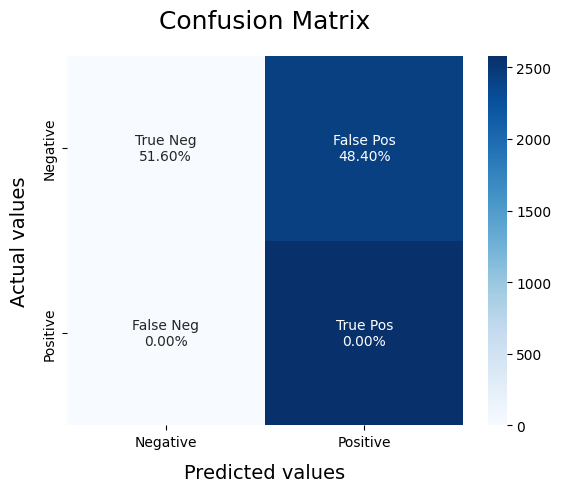

In [38]:
#confusion matrix_2
cm_2=confusion_matrix(sentiment_data,prediction_sentiments_array_2,labels=[1,0])
print(cm_2)


categories = ['Negative', 'Positive']
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_percentages = ['{0:.2%}'.format(value) for value in cm_2.flatten() / np.sum(cm_2)]

# Arrange labels in the correct order
labels = [
    f'{group_names[3]}\n{group_percentages[3]}',  # True Neg
    f'{group_names[1]}\n{group_percentages[1]}',  # False Pos
    f'{group_names[2]}\n{group_percentages[2]}',  # False Neg
    f'{group_names[0]}\n{group_percentages[0]}',  # True Pos
]

# Reshape the labels to match the confusion matrix shape
labels = np.asarray(labels).reshape(2, 2)

sns.heatmap(cm_2, annot=labels, cmap='Blues', fmt='',
            xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)
plt.show()

# Predicting the output for Truncation by Max Count of Tokens

In [41]:
predictions_3 = sentiment_classifier(truncated_reviews_list_3)

In [43]:
# Function to convert predictions to binary values
def convert_predictions_to_binary(predictions, threshold=0.5):
    binary_predictions = []
    for prediction in predictions:
        label = prediction['label']
        score = prediction['score']
        
        if label == 'POSITIVE' and score >= threshold:
            binary_predictions.append(1)
        elif label == 'NEGATIVE' and score >= threshold:
            binary_predictions.append(0)
        else:
            binary_predictions.append(0)  # Default to 0 if score is below the threshold

    return np.array(binary_predictions)


# Convert the list of predictions to binary values
prediction_sentiments_array_3 = convert_predictions_to_binary(predictions_3)

print(prediction_sentiments_array_3)
print(sentiment_data)

[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


**Accuracy of the transformer model by Accuracy Score, F1 Score, ROC-AUC Score**

In [44]:
#Accuracy score
accuracy_3 =accuracy_score(sentiment_data,prediction_sentiments_array_3)
print("accuracy_score :",accuracy_3)

#ROC_AUC score
roc_auc_3=roc_auc_score(sentiment_data,prediction_sentiments_array_3)
print("roc_auc_score :",roc_auc_3)

#F1 score
f1_3=f1_score(sentiment_data,prediction_sentiments_array_3)
print("f1_score :",f1_3)


accuracy_score : 0.516
roc_auc_score : 0.5
f1_score : 0.0


**Print the classification report**

In [45]:
#Classification report for bag of words
report_3=classification_report(sentiment_data,prediction_sentiments_array_3,target_names=['Positive','Negative'])
print(report_3)

#Positive means 1 label and negative means 0 label

              precision    recall  f1-score   support

    Positive       0.52      1.00      0.68      2580
    Negative       0.00      0.00      0.00      2420

    accuracy                           0.52      5000
   macro avg       0.26      0.50      0.34      5000
weighted avg       0.27      0.52      0.35      5000



/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

**Confusion matrix**

[[   0 2420]
 [   0 2580]]


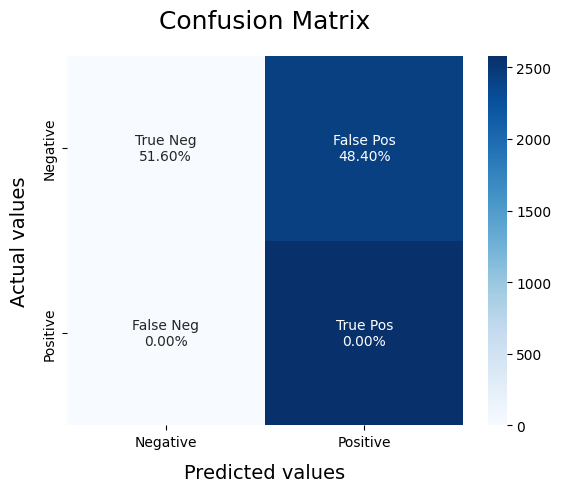

In [46]:
#confusion matrix_3
cm_3=confusion_matrix(sentiment_data,prediction_sentiments_array_3,labels=[1,0])
print(cm_3)


categories = ['Negative', 'Positive']
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_percentages = ['{0:.2%}'.format(value) for value in cm_3.flatten() / np.sum(cm_3)]

# Arrange labels in the correct order
labels = [
    f'{group_names[3]}\n{group_percentages[3]}',  # True Neg
    f'{group_names[1]}\n{group_percentages[1]}',  # False Pos
    f'{group_names[2]}\n{group_percentages[2]}',  # False Neg
    f'{group_names[0]}\n{group_percentages[0]}',  # True Pos
]

# Reshape the labels to match the confusion matrix shape
labels = np.asarray(labels).reshape(2, 2)

sns.heatmap(cm_3, annot=labels, cmap='Blues', fmt='',
            xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)
plt.show()

# **Let us see positive and negative words by using WordCloud.**

**Word cloud for positive review words**

<function matplotlib.pyplot.show(close=None, block=None)>

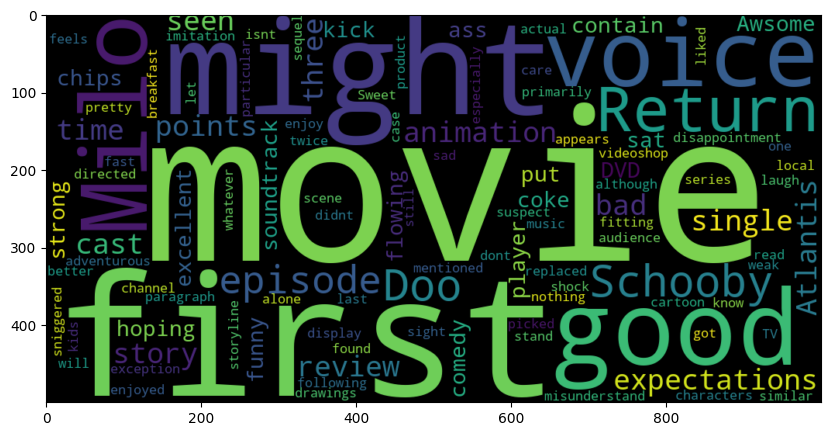

In [47]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=reviews_list[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

**Word cloud for negative review words**

<function matplotlib.pyplot.show(close=None, block=None)>

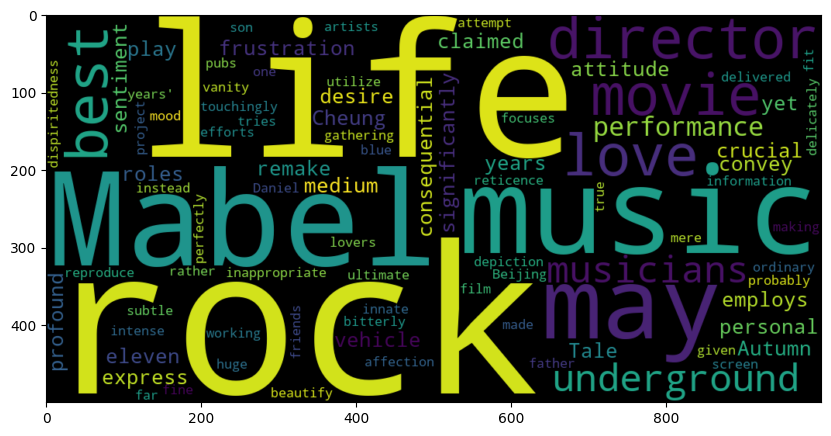

In [48]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=reviews_list[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

# References:
[Some Kaggle Notebooks](https://www.kaggle.com/),
[Medium Articles](https://www.medium.com),
[GfG Articles](https://www.geeksforgeeks.org/),
Google Search
